# Mask R-CNN Model


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py 

# mrcnn import
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib

# 设置 ROOT_DIR 为 project 根目录（即包含 RCNN_model 的那层）
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)
print("ROOT_DIR:", ROOT_DIR)

# 日志路径
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Weights Download if working direcotry missing `coco weights`
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

def convert_and_load_weights(model, coco_weights_path, mode='mean'):
    """
    Load COCO weights into a Mask R-CNN model with 4-channel input.

    Args:
        model: The Mask R-CNN model object.
        coco_weights_path: Path to the original 3-channel COCO .h5 weights.
        mode: How to initialize the 4th channel:
            - 'mean': use the average of RGB channels (default)
            - 'zero': use all zeros
            - 'constant': copy the R channel
    """
    try:
        with h5py.File(coco_weights_path, mode='r') as f:
            # Load original conv1 weights from COCO (shape: 7,7,3,64)
            pretrained_kernel = f['conv1']['conv1']['kernel:0'][:]
            pretrained_bias = f['conv1']['conv1']['bias:0'][:]
            
            assert pretrained_kernel.shape == (7, 7, 3, 64), "Unexpected conv1 kernel shape."

            # Create the 4th channel weights based on the selected mode
            if mode == 'mean':
                # Use the mean of the RGB channels as the 4th (NIR) channel
                fourth_channel = np.mean(pretrained_kernel, axis=2, keepdims=True)
            elif mode == 'zero':
                # Initialize the 4th channel with zeros
                fourth_channel = np.zeros_like(pretrained_kernel[:, :, :1, :])
            elif mode == 'constant':
                # Copy the R channel as the 4th channel
                fourth_channel = pretrained_kernel[:, :, :1, :]
            else:
                raise ValueError(f"Invalid mode: {mode}. Choose 'mean', 'zero', or 'constant'.")

            # Concatenate to form (7, 7, 4, 64) kernel weights
            new_kernel = np.concatenate([pretrained_kernel, fourth_channel], axis=2)
            
            # Load all other weights except for conv1 and the output heads
            model.load_weights(coco_weights_path, by_name=True, exclude=[
                "conv1", "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"
            ])
            
            # Set the new conv1 weights with 4 input channels
            conv1_layer = [l for l in model.keras_model.layers if l.name == "conv1"][0]
            conv1_layer.set_weights([new_kernel, pretrained_bias])

            print("✅ COCO weights loaded with adapted conv1 (4 channels)")
            print(f"   → New kernel shape: {new_kernel.shape}")
    except Exception as e:
        print(f"❌ Error loading and converting weights: {e}")

    # Print the conv1 weight shape for verification
    conv1_layer = [l for l in model.keras_model.layers if l.name == "conv1"][0]
    kernel_weights = conv1_layer.get_weights()[0]
    print(f"✅ conv1 new shape: {kernel_weights.shape}")  # Should be (7, 7, 4, 64)


ROOT_DIR: /Users/evanchan19/Desktop/COMP9517/project


Using TensorFlow backend.


## Configurations

In [2]:
import numpy as np
from mrcnn.config import Config

class USAConfig(Config):
    """Configuration for 4-channel input (RGB + NIR)"""
    NAME = "usa_rgbn"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 1  # background + dead tree

    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512
    IMAGE_RESIZE_MODE = "square"

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 200
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5

    LEARNING_RATE = 0.0013
    LEARNING_MOMENTUM = 0.9
    USE_MINI_MASK = False

    IMAGE_CHANNEL_COUNT = 4
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])  # R, G, B, NIR

class USAConfigRGB(Config):
    """Configuration for standard 3-channel RGB input"""
    NAME = "usa_rgb"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 1  # background + dead tree

    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512
    IMAGE_RESIZE_MODE = "square"

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 200
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5

    LEARNING_RATE = 0.0013
    LEARNING_MOMENTUM = 0.9
    USE_MINI_MASK = False

    IMAGE_CHANNEL_COUNT = 3
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])  # R, G, B

# Usage example:
config_4ch = USAConfig()
config_3RGB = USAConfigRGB()

# Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

## Step 1) Data Preprocessing

In [3]:
from mrcnn import utils

class USADataset(utils.Dataset):
    def __init__(self, input_type="RGB"):
        """
        input_type: "RGB", "NRG", or "RGB+NRG"
        """
        super().__init__()
        assert input_type in ["RGB", "NRG", "RGB+NRG"]
        self.input_type = input_type

    def load_usa(self, dataset_dir, subset):
        assert subset in ["train", "val"]

        if self.input_type == "RGB+NRG":
            image_dir = os.path.join(dataset_dir, subset, "RGB_images")
            nrg_dir = os.path.join(dataset_dir, subset, "NRG_images")
        else:
            image_dir = os.path.join(dataset_dir, subset, f"{self.input_type}_images")

        mask_dir = os.path.join(dataset_dir, subset, "masks")

        self.add_class("usa", 1, "object")

        for filename in os.listdir(image_dir):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path = os.path.join(image_dir, filename)

            if self.input_type == "RGB+NRG":
                core_name = filename.replace("RGB_", "").replace("rgb_", "")
                nrg_path = os.path.join(nrg_dir, f"NRG_{core_name}")
            else:
                prefix = f"{self.input_type}_".lower()
                core_name = filename.lower().replace(prefix, "")

            mask_filename = f"mask_{core_name}"
            mask_path = os.path.join(mask_dir, mask_filename)

            if not os.path.exists(mask_path):
                print(f"⚠️ Missing mask: {mask_path}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"❌ Failed to read image: {img_path}")
                continue
            height, width = img.shape[:2]

            if self.input_type == "RGB+NRG":
                if not os.path.exists(nrg_path):
                    print(f"⚠️ Missing NRG image: {nrg_path}")
                    continue
                self.add_image(
                    source="usa",
                    image_id=filename,
                    path=img_path,
                    width=width,
                    height=height,
                    mask_path=mask_path,
                    nrg_path=nrg_path
                )
            else:
                self.add_image(
                    source="usa",
                    image_id=filename,
                    path=img_path,
                    width=width,
                    height=height,
                    mask_path=mask_path
                )

    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = cv2.imread(info["path"])
        if img is None:
            raise ValueError(f"❌ Failed to load image: {info['path']}")

        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.input_type == "RGB":
            return rgb_img
        elif self.input_type == "NRG":
            return img
        elif self.input_type == "RGB+NRG":
            nrg_path = info.get("nrg_path")
            if not nrg_path or not os.path.exists(nrg_path):
                raise ValueError(f"❌ Missing or invalid 'nrg_path' for image_id {image_id}: {nrg_path}")
            nrg_img = cv2.imread(nrg_path)
            if nrg_img is None:
                raise ValueError(f"❌ Failed to load NRG image: {nrg_path}")
            nir = nrg_img[:, :, 0:1]

            # Sanity check
            if rgb_img.shape[:2] != nir.shape[:2]:
                raise ValueError(f"❌ RGB and NIR size mismatch: {rgb_img.shape[:2]} vs {nir.shape[:2]}")

            return np.concatenate([rgb_img, nir], axis=-1)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask_path = info["mask_path"]
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask_img is None:
            raise ValueError(f"❌ Failed to load mask image: {mask_path}")

        binary_mask = (mask_img == 255).astype(np.uint8)
        num_labels, labels = cv2.connectedComponents(binary_mask)

        masks = []
        for i in range(1, num_labels):
            masks.append((labels == i).astype(np.uint8))

        if masks:
            masks = np.stack(masks, axis=-1)
        else:
            print(f"⚠️ No objects found in mask: {mask_path}")
            masks = np.zeros((mask_img.shape[0], mask_img.shape[1], 0), dtype=np.uint8)

        class_ids = np.ones(masks.shape[-1], dtype=np.int32)
        return masks.astype(bool), class_ids

    
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("loss", None)
        val_loss = logs.get("val_loss", None)
        self.epoch_loss.append(loss)
        self.val_loss.append(val_loss)
        print(f"📉 Epoch {epoch+1}: loss={loss:.4f}, val_loss={val_loss:.4f}")

### 1.2 Prepare Datasets

In [4]:
def prepare_datasets(dataset_dir, input_type="RGB+NRG"):
    """Load and prepare train and validation datasets."""
    dataset_train = USADataset(input_type=input_type)
    dataset_train.load_usa(dataset_dir, "train")
    dataset_train.prepare()

    dataset_val = USADataset(input_type=input_type)
    dataset_val.load_usa(dataset_dir, "val")
    dataset_val.prepare()

    return dataset_train, dataset_val

### 1.3     Data Argumentation

In [5]:
# Data Argmentation
import imgaug.augmenters as iaa

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),                            # 水平翻转（不改变目标结构）
    iaa.Affine(
        rotate=(-5, 5),                         # 极小角度旋转
        scale=(0.95, 1.05),                     # 微缩放
        translate_percent={"x": (-0.05, 0.05),
                           "y": (-0.05, 0.05)}  # 轻微平移
    ),
    iaa.SomeOf((1, 2), [
        iaa.Multiply((0.9, 1.1)),               # 光照波动
        iaa.LinearContrast((0.9, 1.1)),         # 对比度轻微变化
        iaa.GaussianBlur(sigma=(0.0, 0.5)),     # 轻微模糊
    ])
], random_order=True)

## Step 2)  Create Model

In [6]:
import os

def initialize_model_weights(model, init_with, is_4_channel, coco_model_path):
    """
    Initialize Mask R-CNN model weights.

    Args:
        model (MaskRCNN): The Mask R-CNN model instance.
        init_with (str): Initialization method - "imagenet", "coco", or "last".
        is_4_channel (bool): Whether the model input has 4 channels.
        coco_model_path (str): Path to COCO weights file.
    """
    if init_with == "imagenet":
        print("[INFO] Initializing weights from ImageNet (ResNet backbone only)...")
        model.load_weights(model.get_imagenet_weights(), by_name=True)

    elif init_with == "coco":
        print("[INFO] Initializing weights from COCO dataset...")
        if not os.path.exists(coco_model_path):
            raise FileNotFoundError(f"COCO weights not found at: {coco_model_path}")

        if is_4_channel:
            print("[INFO] Adapting first conv layer for 4-channel input and loading COCO weights...")
            convert_and_load_weights(model, coco_model_path)  # Your custom function to adapt weights
        else:
            print("[INFO] Loading COCO weights excluding classification and mask heads...")
            model.load_weights(
                coco_model_path,
                by_name=True,
                exclude=[
                    "mrcnn_class_logits",
                    "mrcnn_bbox_fc",
                    "mrcnn_bbox",
                    "mrcnn_mask"
                ]
            )

    elif init_with == "last":
        print("[INFO] Resuming training from last checkpoint...")
        model_path = model.find_last()
        if not model_path:
            raise FileNotFoundError("No previous model checkpoint found in logs directory.")
        model.load_weights(model_path, by_name=True)
        print("[INFO] Successfully loaded model weights from:", model_path)

    else:
        raise ValueError(f"Unknown init_with option: {init_with}")


## Step 3) Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Train Part 3.2:     4 channel training

In [ ]:
# ============================================================
# Train the Mask R-CNN model on your custom USA RGB dataset
# ============================================================

# Train the head branches
# Passing layers="heads" freezes all layers except the head layers.

# layers="all" for full fine-tuning
# or use NRG input by switching input_type="NRG" in USADataset

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
import keras.backend as K
dataset_dir = "/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation"
print_lr = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                          print(f"Epoch {epoch+1}: current LR = {K.get_value(model.keras_model.optimizer.lr):.6f}"))

# ======================
# ⚙️ Configuration
# ======================
input_type = "RGB+NRG"  # Change to: "RGB", "NRG", or "RGB+NRG"
dataset_train, dataset_val = prepare_datasets(dataset_dir, input_type)

history = LossHistory()
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor validation loss
    factor=0.5,  patience=2,    # Reduce LR by a factor of 0.5 and Reduce LR if val_loss does not improve for 2 epochs
    min_lr=1e-6, verbose=1      # Minimum learning rate
)

model = modellib.MaskRCNN(mode="training", config = config_4ch, model_dir=MODEL_DIR)            # Key Config
initialize_model_weights(model=model,
    init_with="coco",                   # Options: "imagenet", "coco", or "last"
    is_4_channel=True,                  # True if using 4-channel input images
    coco_model_path=COCO_MODEL_PATH     # Path to your COCO weights file
)

# -----------------------
# PHASE 1: Train Heads
model.train(dataset_train, dataset_val, learning_rate=0.001, epochs=10, layers='heads',
    custom_callbacks=[history, lr_scheduler, print_lr])

# -----------------------
# PHASE 2: Fine-tune all layers
model.train(dataset_train, dataset_val, learning_rate=0.0008,  
    epochs=20,             # Continue training, set as appropriate
    layers='all',          # 🔥 Train all layers!
    custom_callbacks=[history, lr_scheduler, print_lr]
)

### Train Part 3.2:   3 channel training (RGB)

In [ ]:
# ======================
# ⚙️ Configuration
# ======================
input_type = "RGB"  # Change to: "RGB", "NRG", or "RGB+NRG"
dataset_train, dataset_val = prepare_datasets(dataset_dir, input_type)

model = modellib.MaskRCNN(mode="training", config = config_3RGB, model_dir=MODEL_DIR)
initialize_model_weights(model=model,
    init_with="coco",                   # Options: "imagenet", "coco", or "last"
    is_4_channel=False,                 # True if using 4-channel input images
    coco_model_path=COCO_MODEL_PATH     # Path to your COCO weights file
)

model.train(dataset_train, dataset_val, learning_rate=0.0013,
    epochs=15, layers='heads',     
    custom_callbacks=[history, lr_scheduler, print_lr]
)


## Detection and Evaluation

### 1） Visual

In [29]:
# --------------------
# Config and Model Setup
# --------------------
class InferenceConfig(Config):
    NAME = "usa_dead_tree"
    NUM_CLASSES = 1 + 1  # Background + dead tree
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.1

    def __init__(self, input_type="RGB"):
        super().__init__()
        assert input_type in ["RGB", "NRG", "RGB+NRG"], "Invalid input_type!"
        self.input_type = input_type
        if input_type == "RGB":
            self.IMAGE_CHANNEL_COUNT = 3
            self.MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
        elif input_type == "NRG":
            self.IMAGE_CHANNEL_COUNT = 3
            self.MEAN_PIXEL = np.array([103.9, 116.8, 123.7])  # Example, adjust as needed
        elif input_type == "RGB+NRG":
            self.IMAGE_CHANNEL_COUNT = 4
            self.MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])
            
input_type = "RGB+NRG"  # Change to: "RGB", "NRG", or "RGB+NRG"
dataset_dir = "/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation"
dataset_train, dataset_val = prepare_datasets(dataset_dir, input_type)

Pre-trained model is loaded from /Users/evanchan19/Desktop/COMP9517/project/model/usa_rgb_nrg_resnet101/mask_rcnn_usa_rgb_0015.h5


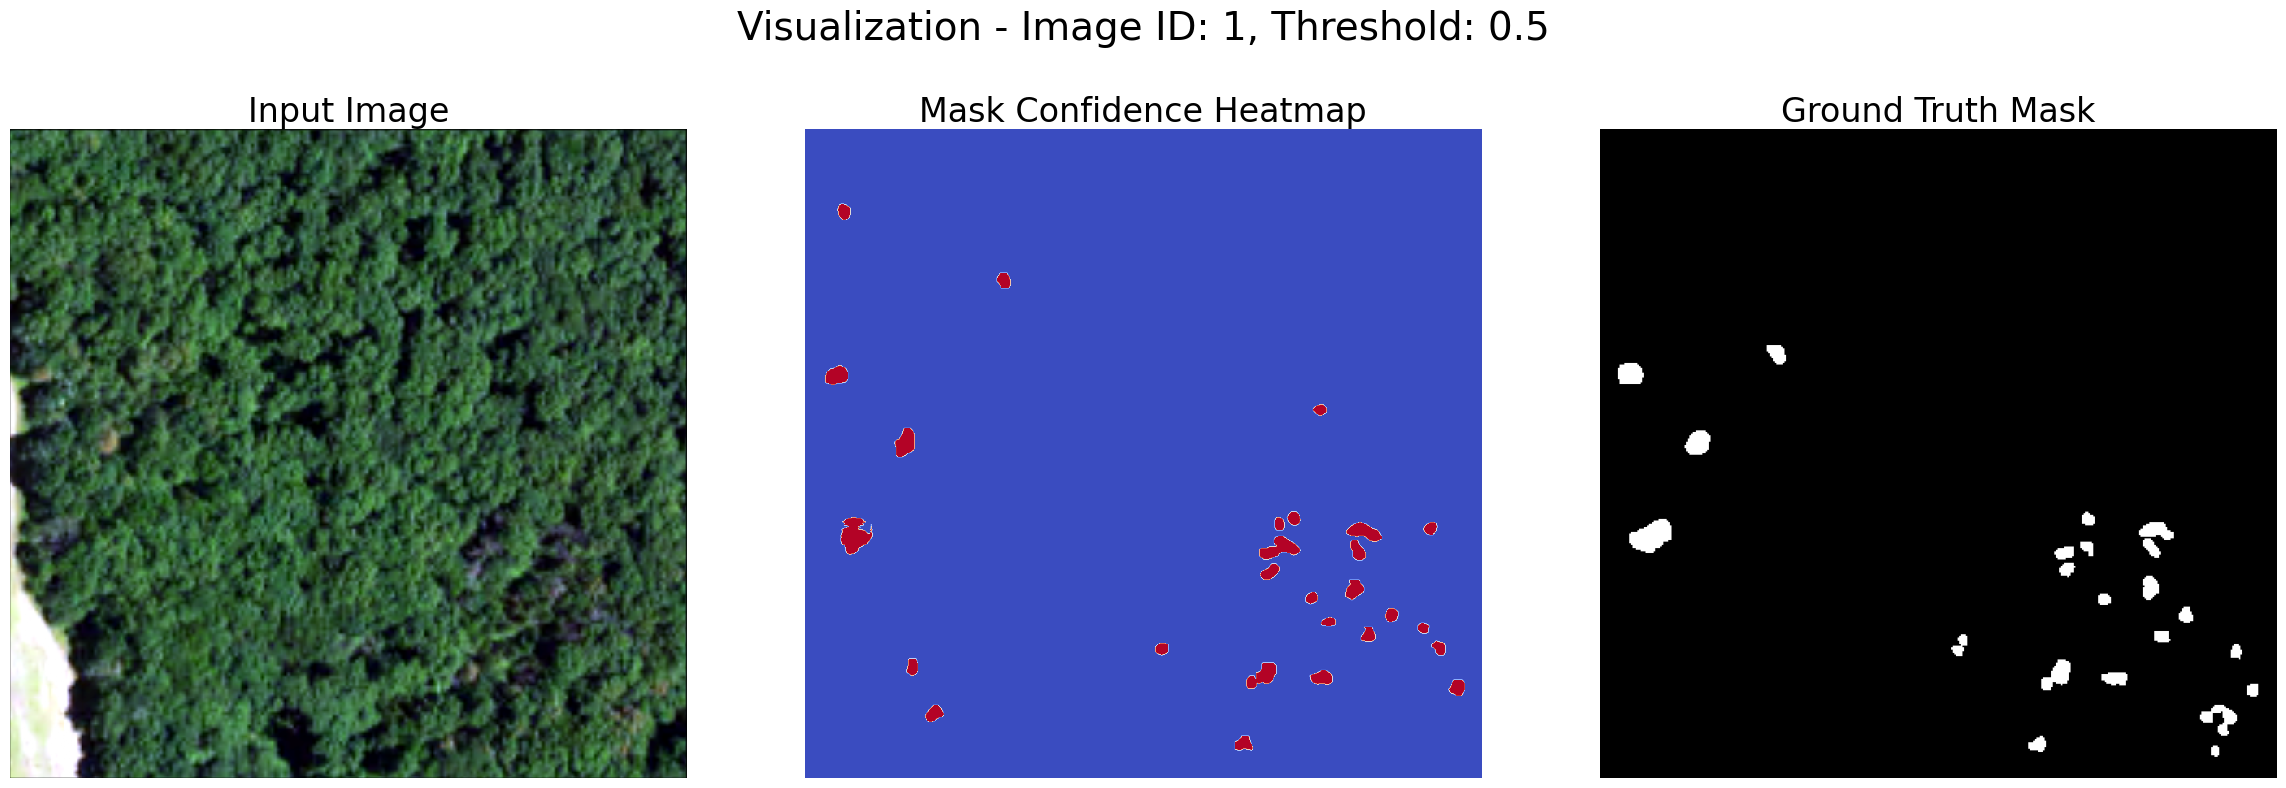

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mrcnn import visualize, model as modellib
from mrcnn.config import Config

# --------------------
# Config and Model Setup
# --------------------
inference_config = InferenceConfig(input_type=input_type)

model_path = "/Users/evanchan19/Desktop/COMP9517/project/model/usa_rgb_nrg_resnet101/mask_rcnn_usa_rgb_0015.h5"
print(f"Pre-trained model is loaded from {model_path}")
inference_model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="./logs")
inference_model.load_weights(model_path, by_name=True)

# --------------------
# Load One Validation Image
image_id = dataset_val.image_ids[1]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

# --------------------
# Run Inference
results = inference_model.detect([original_image], verbose=0)
r = results[0]
threshold = 0.5

# --------------------
# Show All: GT vs Prediction vs Mask Confidence
def crop_non_black(image):
    gray = np.mean(image[:, :, :3], axis=2)  # 灰度化
    mask = gray > 0
    coords = np.argwhere(mask)
    if coords.size == 0:
        return image  # 全黑图，直接返回
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    return image[y0:y1, x0:x1], (y0, y1, x0, x1)

def crop_mask_with_coords(mask, coords):
    y0, y1, x0, x1 = coords
    return mask[y0:y1, x0:x1]

def plot_input_heatmap_gt(original_image, gt_mask, r, image_id=None, threshold=None, title_fontsize=24):
    # crop input image
    cropped_img, coords = crop_non_black(original_image)
    img = cropped_img[:, :, :3]
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Crop heatmap
    heatmap = np.max(r["masks"].astype(np.float32), axis=-1)
    heatmap_cropped = crop_mask_with_coords(heatmap, coords)

    # Crop mask
    gt_merged = np.max(gt_mask.astype(np.float32), axis=-1)
    gt_merged_cropped = crop_mask_with_coords(gt_merged, coords)

    # Compose title
    title_str = "Visualization"
    if image_id is not None:
        title_str += f" - Image ID: {image_id}"
    if threshold is not None:
        title_str += f", Threshold: {threshold}"

    # Plot 
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(title_str, fontsize=title_fontsize + 4)

    axes[0].imshow(img, interpolation='none')
    axes[0].set_title("Input Image", fontsize=title_fontsize)
    axes[0].axis("off")

    axes[1].imshow(heatmap_cropped, cmap="coolwarm", vmin=0, vmax=1)
    axes[1].set_title("Mask Confidence Heatmap", fontsize=title_fontsize)
    axes[1].axis("off")

    axes[2].imshow(gt_merged_cropped, cmap="gray")
    axes[2].set_title("Ground Truth Mask", fontsize=title_fontsize)
    axes[2].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.83)
    plt.show()

# Picture No.1
plot_input_heatmap_gt(original_image, gt_mask, r, image_id=image_id, threshold=threshold)

### Visualize the best and worst segementation output

Image idx 0: Image ID 0, IoU = 0.141
Image idx 1: Image ID 1, IoU = 0.484
Image idx 2: Image ID 2, IoU = 0.116
Image idx 3: Image ID 3, IoU = 0.197
Image idx 4: Image ID 4, IoU = 0.354
Image idx 5: Image ID 5, IoU = 0.409
Image idx 6: Image ID 6, IoU = 0.318
Image idx 7: Image ID 7, IoU = 0.166
Image idx 8: Image ID 8, IoU = 0.302
Image idx 9: Image ID 9, IoU = 0.198
Image idx 10: Image ID 10, IoU = 0.333
Image idx 11: Image ID 11, IoU = 0.139
Image idx 12: Image ID 12, IoU = 0.239
Image idx 13: Image ID 13, IoU = 0.201
Image idx 14: Image ID 14, IoU = 0.254
Image idx 15: Image ID 15, IoU = 0.388
Image idx 16: Image ID 16, IoU = 0.403
Image idx 17: Image ID 17, IoU = 0.348
Image idx 18: Image ID 18, IoU = 0.297
Image idx 19: Image ID 19, IoU = 0.294
Image idx 20: Image ID 20, IoU = 0.136
Image idx 21: Image ID 21, IoU = 0.190
Image idx 22: Image ID 22, IoU = 0.249
Image idx 23: Image ID 23, IoU = 0.214
Image idx 24: Image ID 24, IoU = 0.165
Image idx 25: Image ID 25, IoU = 0.248
Image 

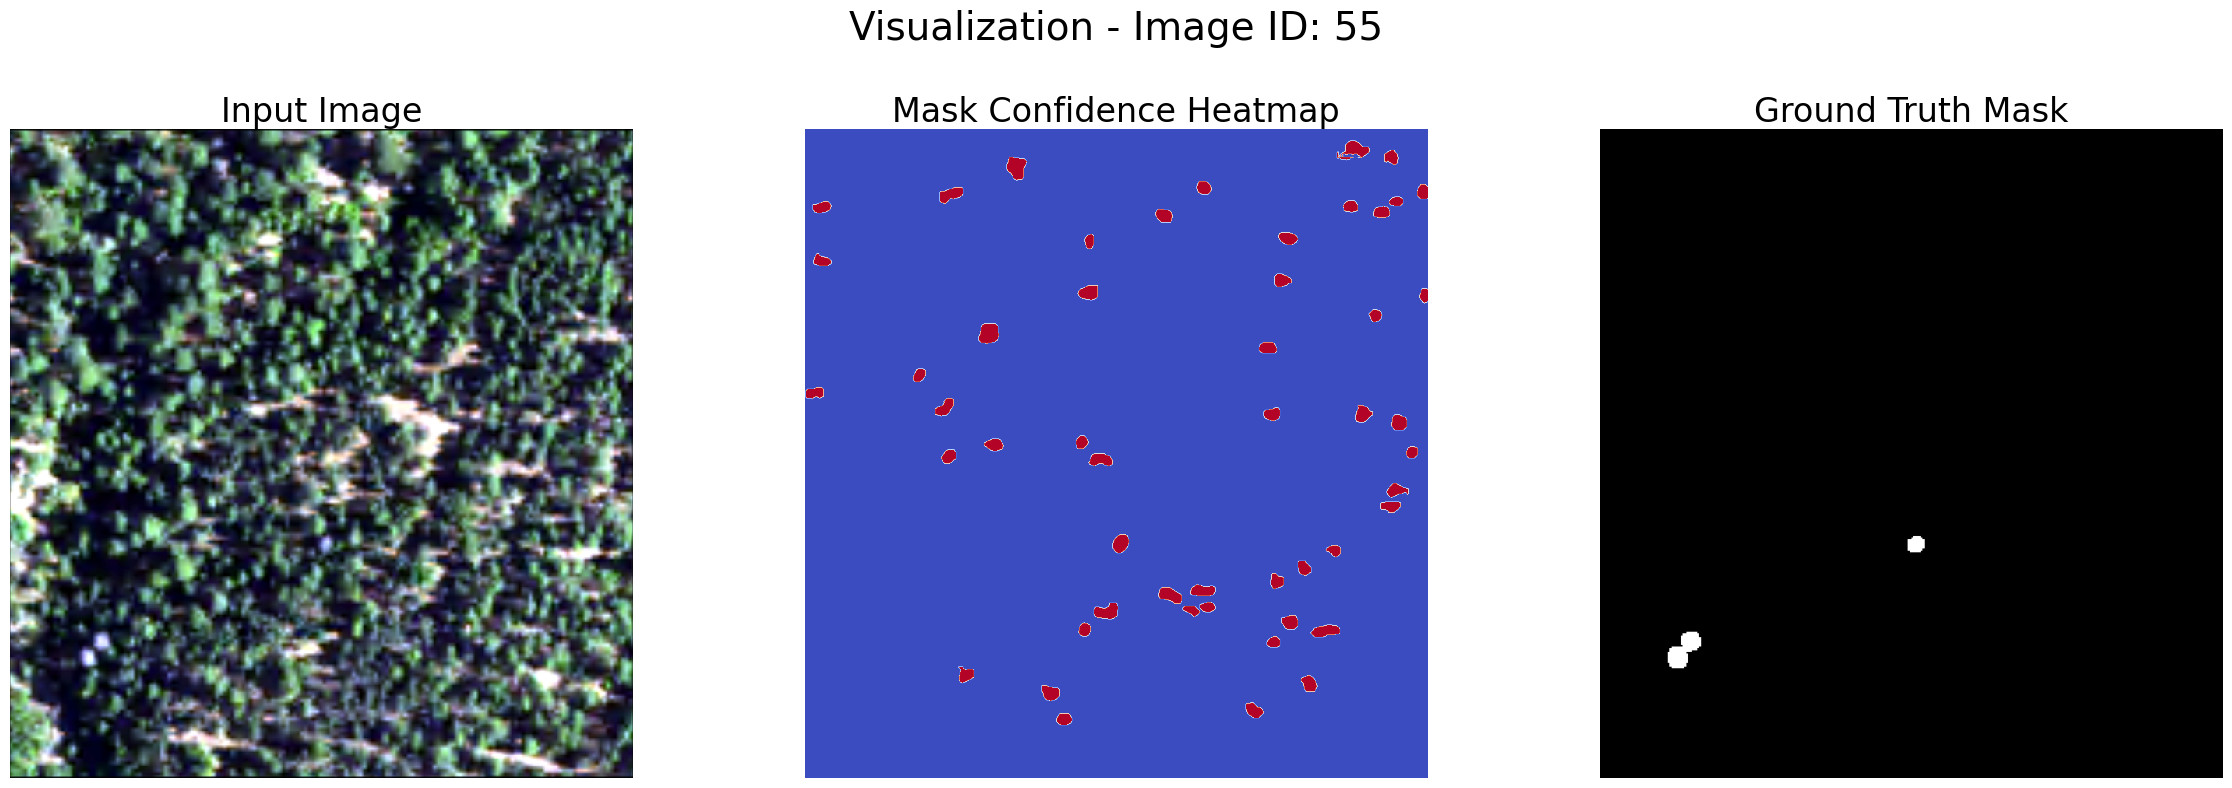

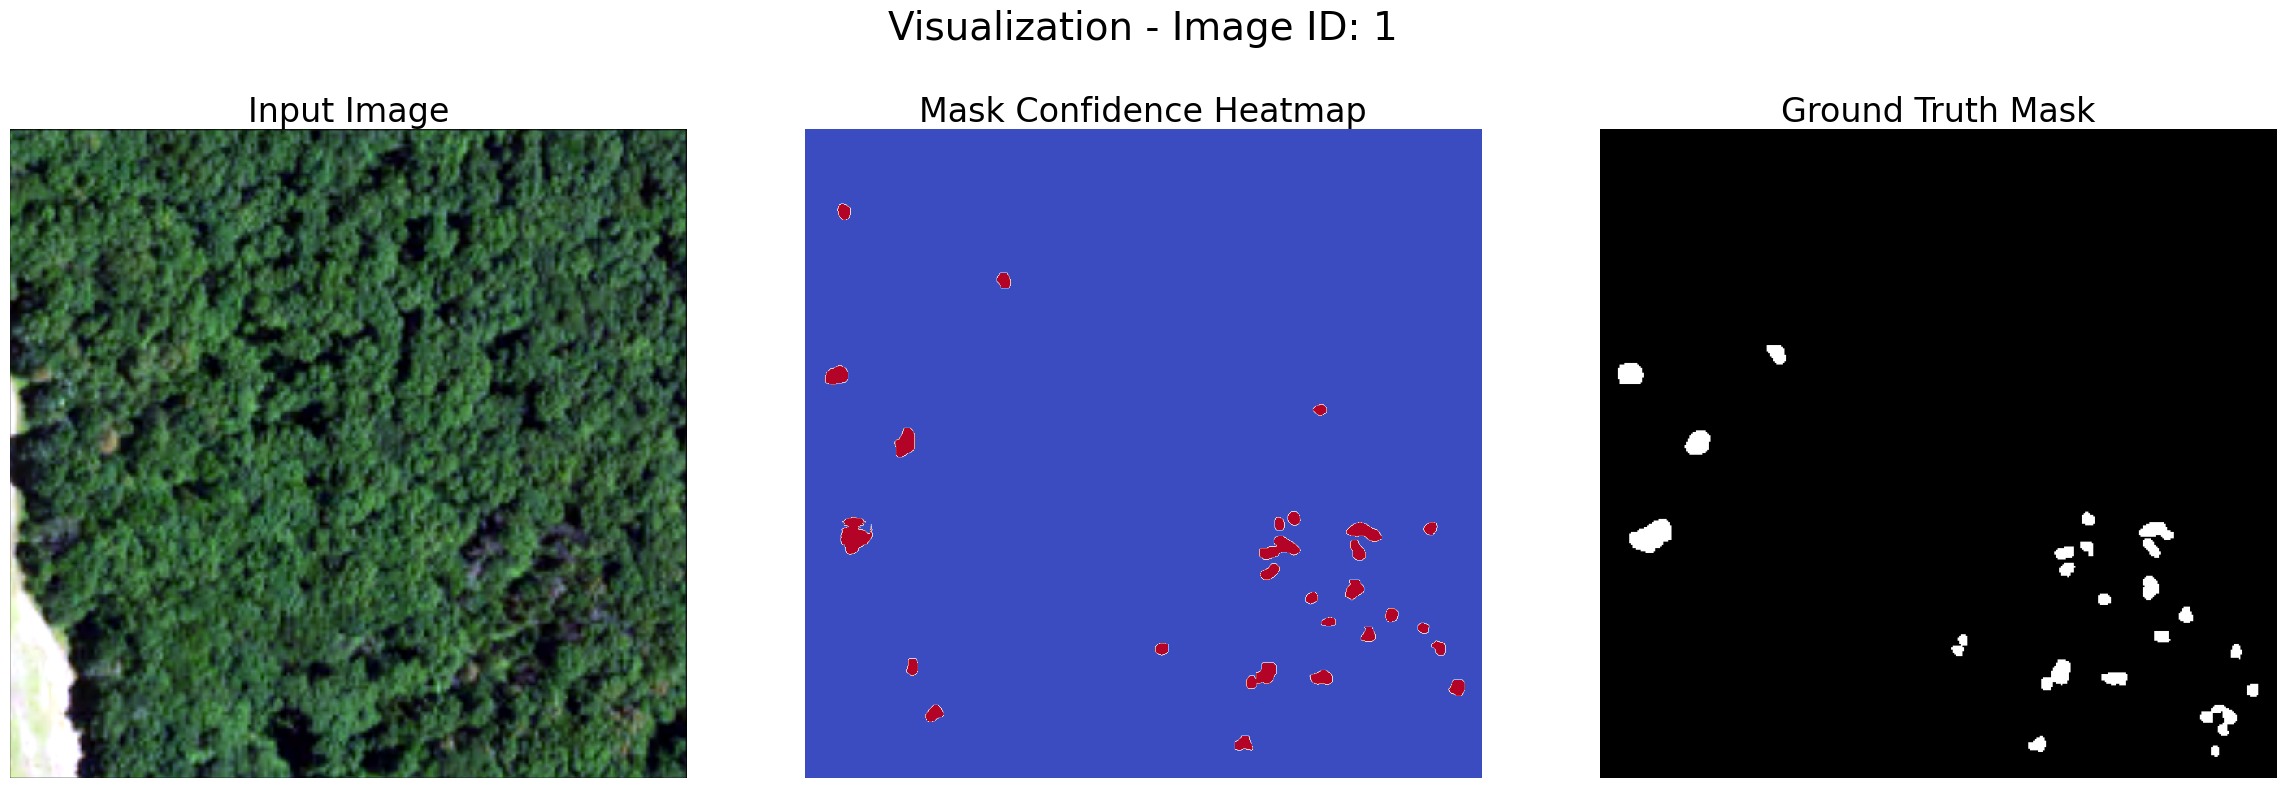

In [24]:
def compute_iou(pred_mask, gt_mask):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0

# Initialize variables for best and worst cases
worst_iou = 1.0
worst_idx = -1
worst_result = None
worst_gt_mask = None
worst_original_image = None
worst_image_id = None

best_iou = -1.0
best_idx = -1
best_result = None
best_gt_mask = None
best_original_image = None
best_image_id = None

for idx, image_id in enumerate(dataset_val.image_ids):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    if gt_mask.size == 0 or gt_mask.shape[-1] == 0:
        print(f"⚠️ No ground truth mask in image idx {idx} (Image ID {image_id}), skip.")
        continue

    results = inference_model.detect([original_image], verbose=0)
    r = results[0]

    pred_mask = np.max(r["masks"], axis=-1) if r["masks"].shape[-1] > 0 else np.zeros(original_image.shape[:2], dtype=np.uint8)
    gt_mask_merged = np.max(gt_mask, axis=-1)

    iou = compute_iou(pred_mask > 0.5, gt_mask_merged > 0.5)
    print(f"Image idx {idx}: Image ID {image_id}, IoU = {iou:.3f}")

    # Update worst IoU
    if iou < worst_iou:
        worst_iou = iou
        worst_idx = idx
        worst_result = r
        worst_gt_mask = gt_mask
        worst_original_image = original_image
        worst_image_id = image_id

    # Update best IoU
    if iou > best_iou:
        best_iou = iou
        best_idx = idx
        best_result = r
        best_gt_mask = gt_mask
        best_original_image = original_image
        best_image_id = image_id

print(f"\nWorst image found: idx {worst_idx}, Image ID {worst_image_id}, IoU = {worst_iou:.3f}")
print(f"Best image found:  idx {best_idx}, Image ID {best_image_id}, IoU = {best_iou:.3f}")

plot_input_heatmap_gt(
    worst_original_image,
    worst_gt_mask,
    worst_result,
    image_id=f"{worst_image_id} Worst mIoU Detection",
    title_fontsize=24
)

plot_input_heatmap_gt(
    best_original_image,
    best_gt_mask,
    best_result,
    image_id=f"{best_image_id} Best mIoU Detection",
    title_fontsize=24
)


In [ ]:
def compute_iou(pred_mask, gt_mask):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0

# Initialize variables for best and worst cases
worst_iou = 1.0
worst_idx = -1
worst_result = None
worst_gt_mask = None
worst_original_image = None
worst_image_id = None

best_iou = -1.0
best_idx = -1
best_result = None
best_gt_mask = None
best_original_image = None
best_image_id = None

for idx, image_id in enumerate(dataset_val.image_ids):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    if gt_mask.size == 0 or gt_mask.shape[-1] == 0:
        print(f"⚠️ No ground truth mask in image idx {idx} (Image ID {image_id}), skip.")
        continue

    results = inference_model.detect([original_image], verbose=0)
    r = results[0]

    pred_mask = np.max(r["masks"], axis=-1) if r["masks"].shape[-1] > 0 else np.zeros(original_image.shape[:2], dtype=np.uint8)
    gt_mask_merged = np.max(gt_mask, axis=-1)

    iou = compute_iou(pred_mask > 0.5, gt_mask_merged > 0.5)
    print(f"Image idx {idx}: Image ID {image_id}, IoU = {iou:.3f}")

    # Update worst IoU
    if iou < worst_iou:
        worst_iou = iou
        worst_idx = idx
        worst_result = r
        worst_gt_mask = gt_mask
        worst_original_image = original_image
        worst_image_id = image_id

    # Update best IoU
    if iou > best_iou:
        best_iou = iou
        best_idx = idx
        best_result = r
        best_gt_mask = gt_mask
        best_original_image = original_image
        best_image_id = image_id

print(f"\nWorst image found: idx {worst_idx}, Image ID {worst_image_id}, IoU = {worst_iou:.3f}")
print(f"Best image found:  idx {best_idx}, Image ID {best_image_id}, IoU = {best_iou:.3f}")

### 2) IOU display

In [ ]:
from mrcnn import utils
import numpy as np
from mrcnn import model as modellib
    
def compute_mask_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0.0

def evaluate_mask_iou_across_thresholds(threshold_list, dataset_val, base_config, model_weights_path):
    results_summary = []
    image_ids = dataset_val.image_ids
    all_image_ious = {image_id: [] for image_id in image_ids}
    

    for threshold in threshold_list:
        class EvalConfig(base_config.__class__):
            NAME = "eval"
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            IMAGE_CHANNEL_COUNT = 4
            MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])
            DETECTION_MIN_CONFIDENCE = threshold
        inference_config = EvalConfig()

        model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="./logs")
        model.load_weights(model_weights_path, by_name=True)

        iou_per_image = []

        for image_id in image_ids:
            image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
                dataset_val, inference_config, image_id, use_mini_mask=False
            )

            results = model.detect([image], verbose=0)
            r = results[0]

            pred_masks = r["masks"]
            gt_masks = gt_mask

            best_ious = []
            for i in range(gt_masks.shape[-1]):
                gt = gt_masks[:, :, i]
                ious = [compute_mask_iou(pred_masks[:, :, j], gt) for j in range(pred_masks.shape[-1])]
                best_iou = max(ious) if ious else 0.0
                best_ious.append(best_iou)

            avg_iou = np.mean(best_ious) if best_ious else 0.0
            iou_per_image.append(avg_iou)
            all_image_ious[image_id].append(avg_iou)

        # 剔除特别低的 IoU 值（例如 IoU ≤ 0.1）
        filtered_ious = [v for v in iou_per_image if v > 0.1]
        overall_iou = np.mean(iou_per_image)
        filtered_avg = np.mean(filtered_ious) if filtered_ious else 0.0

        results_summary.append((threshold, overall_iou, filtered_avg))

        print(f"\n✅ Threshold {threshold:.2f} →")
        print(f"- Overall mIoU: {overall_iou:.3f}")
        print(f"- Filtered mIoU (IoU > 0.1): {filtered_avg:.3f}")

    print("\n==== Summary ====")
    for t, raw, filt in results_summary:
        print(f"Threshold {t:.2f} → mIoU: {raw:.3f}, Filtered mIoU: {filt:.3f}")

    return all_image_ious, results_summary

        
weights_list = [
    ("/Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250730T2338/mask_rcnn_usa_rgb_0010.h5", "Epoch 10"),
    ("/Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250730T2338/mask_rcnn_usa_rgb_0011.h5", "Epoch 12"),
    ("/Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250730T2338/mask_rcnn_usa_rgb_0012.h5", "Epoch 13")
]

thresholds = [0.5]
for weight_path, label in weights_list:
    print(f"\n==================== {label} ====================")
    evaluate_mask_iou_across_thresholds(thresholds, dataset_val, inference_config, weight_path)


In [ ]:
import numpy as np
from mrcnn.config import Config
    
class InferenceConfig(Config):
    NAME = "usa_rgb"  
    NUM_CLASSES = 1 + 1  # Background + your class (adjust accordingly)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.75
    IMAGE_CHANNEL_COUNT = 4
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])  # R, G, B, NIR
    

def compute_mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

def evaluate_all_metrics(
    threshold_list, dataset_val, base_config, model_weights_path,
    iou_match_thresholds=[0.5, 0.75]
):
    all_results = []

    for det_conf_thresh in threshold_list:
        # 构建推理 config
        class InferenceConfig(base_config.__class__):
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            DETECTION_MIN_CONFIDENCE = det_conf_thresh
            IMAGE_CHANNEL_COUNT = 4
            MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])
        config = InferenceConfig()

        model = modellib.MaskRCNN(mode="inference", config=config, model_dir="./logs")
        model.load_weights(model_weights_path, by_name=True)

        total_gt, total_pred = 0, 0
        tp, fp, fn = 0, 0, 0
        global_ious = []

        ap_dict = {thr: [] for thr in iou_match_thresholds}
        ar_dict = {thr: [] for thr in iou_match_thresholds}

        for image_id in dataset_val.image_ids:
            image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
                dataset_val, config, image_id, use_mini_mask=False
            )
            if gt_mask.shape[-1] == 0:
                continue

            result = model.detect([image], verbose=0)[0]
            pred_masks = result["masks"]

            # 跳过空预测
            if pred_masks.shape[-1] == 0:
                continue

            # 每张图像的 mIoU（所有GT和Pred的pairwise IoU）
            image_ious = []
            for i in range(gt_mask.shape[-1]):
                gt = gt_mask[:, :, i]
                best_iou = 0
                for j in range(pred_masks.shape[-1]):
                    pred = pred_masks[:, :, j]
                    iou = compute_mask_iou(gt, pred)
                    if iou > best_iou:
                        best_iou = iou
                image_ious.append(best_iou)

            # 过滤掉 IoU < 0.05 的图片
            if np.mean(image_ious) < 0.05:
                continue

            global_ious.extend(image_ious)
            total_gt += gt_mask.shape[-1]
            total_pred += pred_masks.shape[-1]

            matched_gt = set()
            matched_pred = set()

            for i in range(gt_mask.shape[-1]):
                gt = gt_mask[:, :, i]
                best_j = -1
                best_iou = 0
                for j in range(pred_masks.shape[-1]):
                    if j in matched_pred:
                        continue
                    pred = pred_masks[:, :, j]
                    iou = compute_mask_iou(gt, pred)
                    if iou > best_iou:
                        best_iou = iou
                        best_j = j
                if best_j != -1 and best_iou >= min(iou_match_thresholds):
                    matched_gt.add(i)
                    matched_pred.add(best_j)

            tp += len(matched_gt)
            fn += gt_mask.shape[-1] - len(matched_gt)
            fp += pred_masks.shape[-1] - len(matched_pred)

            for thr in iou_match_thresholds:
                matched_gt_thr = set()
                matched_pred_thr = set()
                for i in range(gt_mask.shape[-1]):
                    gt = gt_mask[:, :, i]
                    best_j = -1
                    best_iou = 0
                    for j in range(pred_masks.shape[-1]):
                        if j in matched_pred_thr:
                            continue
                        pred = pred_masks[:, :, j]
                        iou = compute_mask_iou(gt, pred)
                        if iou >= thr and iou > best_iou:
                            best_iou = iou
                            best_j = j
                    if best_j != -1:
                        matched_gt_thr.add(i)
                        matched_pred_thr.add(best_j)
                ap = len(matched_pred_thr) / pred_masks.shape[-1] if pred_masks.shape[-1] > 0 else 0.0
                ar = len(matched_gt_thr) / gt_mask.shape[-1] if gt_mask.shape[-1] > 0 else 0.0
                ap_dict[thr].append(ap)
                ar_dict[thr].append(ar)

        # 输出统计
        mean_iou = np.mean(global_ious) if global_ious else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        print(f"\n📊 DETECTION_CONFIDENCE ≥ {det_conf_thresh:.2f}")
        print(f"➡️ Global mIoU: {mean_iou:.3f}")
        print(f"➡️ Precision: {precision:.3f} | Recall: {recall:.3f}")
        for thr in iou_match_thresholds:
            mean_ap = np.mean(ap_dict[thr]) if ap_dict[thr] else 0.0
            mean_ar = np.mean(ar_dict[thr]) if ar_dict[thr] else 0.0
            print(f"➡️ mAP@IoU={thr:.2f}: {mean_ap:.3f} | AR@IoU={thr:.2f}: {mean_ar:.3f}")

        all_results.append({
            "conf_thresh": det_conf_thresh,
            "mIoU": mean_iou,
            "Precision": precision,
            "Recall": recall,
            "AP": {thr: np.mean(ap_dict[thr]) for thr in iou_match_thresholds},
            "AR": {thr: np.mean(ar_dict[thr]) for thr in iou_match_thresholds},
            "TP": tp, "FP": fp, "FN": fn,
            "Total_GT": total_gt, "Total_Pred": total_pred
        })

    return all_results


# === 你在主程序中调用该函数 ===
inference_config = InferenceConfig()
inference_config.IMAGE_CHANNEL_COUNT = 4
inference_config.MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 114.5])

model_weights_path = "/Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb_nrg_resnet101/mask_rcnn_usa_rgb_0015.h5"
thresholds = [0.5, 0.75]

results = evaluate_all_metrics(
    threshold_list=thresholds,
    dataset_val=dataset_val,
    base_config=inference_config,
    model_weights_path=model_weights_path,
    iou_match_thresholds=[0.5, 0.75]
)
